In [1]:
#%reset -f
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import h5py
from scipy.special import factorial

# Evaluation of analytical expressions

## Introduction

In the paper [add reference once paper is on the arXiv], we derive an approximate short-time propagator for the Fokker-Planck equation. The validate our approximate propagator, we compare it to an exact analytical solution of the Fokker-Planck equation.

In the present notebook, we evaluate both this exact analytical solution of the Fokker-Planck equation, and also use it to calculate some expectation values. 

The discussion below parallels Appendix F of [add reference once paper is on the arXiv].

## Analytical formulas

We start in a coordinate system $y$ and define a length scale $L$ and a time scale $T$.
In the coordinate system $y$, we consider a free-diffusion Fokker-Planck equation with constant diffusivity $D_0 = 1 \cdot  L^2/T$.
The solution to the Fokker-Planck equation with 
initial condition $P(y,t=t_0) = \delta(y - y_0)$ and is then given by
\begin{align}
P_Y(y,t \mid y_0, t_0) &= \frac{1}{\sqrt{4 \pi D_0 \Delta t}} \exp\left[ - \frac{ (y -y_0)^2}{4 D_0 \Delta t}\right],
\end{align}
where $\Delta t = t - t_0$.
This solution fulfills the boundary conditions $P_Y \rightarrow 0$ as $|y/L| \rightarrow \infty$.

With respect to a new coordinate system $x \equiv \Phi(y)$, the free-diffusion Fokker-Planck equation with consistent diffusivity $D_0$ becomes
\begin{align}
\partial_t P = - \partial_x (a P) + \partial_x^2 (D P),
\end{align}
with
\begin{align}
a(x) &= D_0 (\partial_y^2 \Phi)|_{y = \Phi^{-1}(x)},
\\
D(x) &= D_0 \left[ (\partial_y \Phi)|_{y = \Phi^{-1}(x)} \right]^2,
\\
P(x,t \mid x_0, t_0) &= \left.\left[ \left( \frac{d \Phi}{d y}\right)^{-1}
P_Y(y,t\mid y_0, t_0)
\right]\right|_{y=\Phi^{-1}(x)},
\end{align}
where $x_0 = \Phi(y_0)$.

For a given coordinate transformation $\Phi$, we thus can evaluate the drift, diffusivity, and corresponding analytical solution to the Fokker-Planck equation exactly.

We in the following consider the coordinate transformation 
\begin{align}
\Phi(y) &= 0.35 \pi y + L 0.025 \sin(\pi y/L),
\end{align}
and evaluate the resulting drift, diffusivity (as well as their spatial derivatives), and Fokker-Planck solution.

#### Convention in this notebook:

* $y$ is the old coordinate in which the drift vanishes and the diffusivity is constant
* $x \equiv \Phi(y)$ defines the new coordinate
* $\tilde{a}(y) \equiv a(\Phi(y))$ is the drift in the new coordinate, but as a function of the old coordinate
* $\tilde{D}(y) \equiv D(\Phi(y))$ is the diffusivity in the new coordinate, but as a function of the old coordinate

## Define coordinate transformation and its inverse

### $\Phi$

In [2]:
# Define coordinate transformation and calculate its spatial derivative
y = sp.symbols('y',real=True)

Phi = 0.35*sp.pi*y + 0.025*sp.sin(sp.pi*y)
dPhi = sp.diff(Phi,y,1).doit()

Phi_lambda = sp.lambdify(y,Phi)
dPhi_lambda = sp.lambdify(y,dPhi)

#Phi

### $\Phi^{-1}$

We evaluate $y = \Phi^{-1}(x)$ numerically, using scipy.optimize

In [3]:
from scipy import optimize

def Phi_inverse(x):
    global Phi_numerical
    global dPhi_numerical
    '''
    for given x, find y such that \Phi(y) = x
    '''
    #
    sol = optimize.root_scalar(f=lambda y: Phi_lambda(y) - x, 
                               x0=x, 
                               fprime=dPhi_lambda)#, method='newton')
    return sol.root

Phi_inverse_lambda = np.vectorize(Phi_inverse)

print(Phi_inverse_lambda(x=1.))

0.9026082998683101


### Check that $\Phi^{-1} \circ \Phi$, $\Phi \circ \Phi^{-1}$ are the identity function

We want to check that our above implementation of $\Phi^{-1}$ actually gives the inverse function of $\Phi$. 

For this, we evaluate 
\begin{align}
E_1(x) &= (\Phi \circ \Phi^{-1})(x) - x, \\
E_2(y) &= (\Phi^{-1} \circ \Phi)(y) - y.
\end{align}

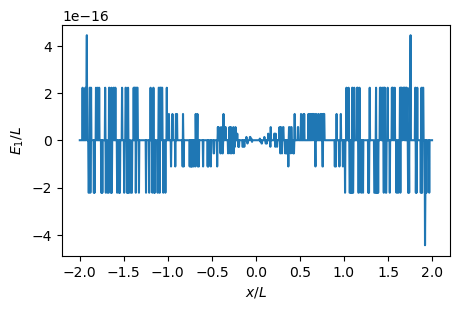

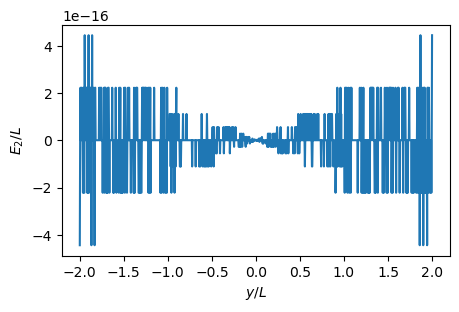

In [4]:
# E_1
xP = np.linspace(-2.,2.,num=1001)
E1 = Phi_lambda(Phi_inverse_lambda(xP)) - xP

fig, ax = plt.subplots(1,1,figsize=(5,3))
ax.plot(xP,E1)
ax.set_xlabel(r'$x/L$')
ax.set_ylabel(r'$E_1/L$')
plt.show()
plt.close(fig)


# E_2
yP = np.linspace(-2.,2.,num=1001)
E2 = Phi_inverse_lambda(Phi_lambda(yP)) - yP

fig, ax = plt.subplots(1,1,figsize=(5,3))
ax.plot(yP,E2)
ax.set_xlabel(r'$y/L$')
ax.set_ylabel(r'$E_2/L$')
plt.show()
plt.close(fig)

We see that both $E_1$ and $E_2$ are zero except for errors of the order of the floating point machine precision. We conclude that our implementation of the inverse function $\Phi^{-1}$ is exact up to rounding errors.

## Parameters for evaluating analytical expressions

In [5]:
dt = np.logspace(-3,1,num=181) # lagtimes at which we evaluate expressions, 
# in units of T

D0 = 1. # in units of L^2/T
x0 = 0.5 # in units of L
L_eval = 5. # in units of L, distance from x0 up to which we evaluate 
            #  expressions
xP = np.linspace(x0-L_eval,x0+L_eval,num=50001,endpoint=True) 

## Implementation of $P(x,t\mid x_0, t_0)$ and its spatial derivatives

For the evaluation of $P$ we use Eq. (F10) from Ref. [1], for the evaluation of the spatial derivatives we use Eq. (F12).

In [6]:
def evaluate_P(x, # array of positions on which to evaluate
        dt, # array of lagtimes for which to evaluate
        x0, # initial position
        n=2, # highest spatial derivative we include in our evaluation
        ):
    #
    global Phi
    global dPhi # d(Phi)/dy
    global Phi_inverse_lambda
    #
    # get y coordinates corresponding to input x coordinates
    y0 = Phi_inverse_lambda(x0)
    yP = Phi_inverse_lambda(x)
    #
    P_out = np.zeros([n+1,len(dt),len(x)],
                        dtype=float)
    # P_out[i,j,k] = i-th spatial derivative of P evaluated at lagtime dt[j]
    #                and position x[k]
    #
    dt_ = sp.symbols('t',real=True,positive=True) # dummy symbol
    for i in range(n+1):
        #
        if i == 0:
            # at zero-th order
            current_derivative = sp.exp(-(y-y0)**2/(4*D0*dt_))/sp.sqrt(4*sp.pi*D0*dt_) 
            current_derivative /= dPhi
            #
        else:
            current_derivative = (sp.diff(current_derivative,y,1)/dPhi).doit()
            #
        #
        current_lambda_func = sp.lambdify((y,dt_),current_derivative)
        for j,cur_dt in enumerate(dt):
            P_out[i,j] = current_lambda_func(yP,cur_dt)
    #
    return y0, yP, P_out

y0, yP, P = evaluate_P(x=xP,x0=x0,dt=dt)

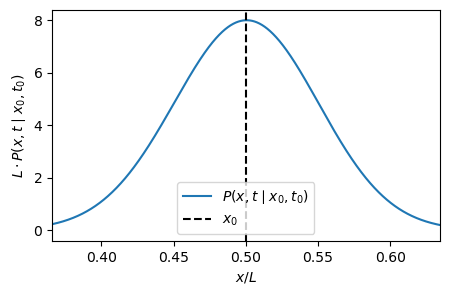

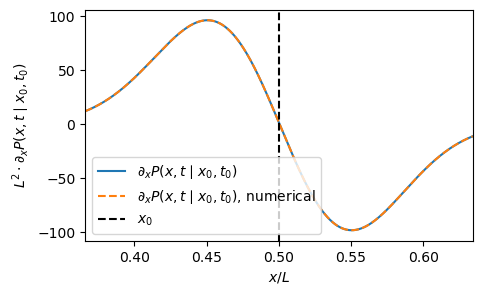

In [7]:
# for testing, we plot the propagator and its first derivative

dt_plot = 1e-3
n_derivatives = [0,1]
dt_index = np.argmin(np.fabs(dt - dt_plot))

labels = {0:r'$P(x,t\mid x_0,t_0)$',
        1:r'$\partial_x P(x,t\mid x_0,t_0)$'}

ylabels = {0:r'$L \cdot P(x,t\mid x_0,t_0)$',
        1:r'$L^2 \cdot \partial_x P(x,t\mid x_0,t_0)$'}

for n in n_derivatives:
    fig, ax = plt.subplots(1,1,figsize=(5,3))
    ax.plot(xP,P[n,dt_index],
            label=labels[n])
    #
    if n == 1:
        # for the first derivative, we add the numerical derivative
        # of the analytical propagator
        dP_dx_numerical = (P[0,dt_index][2:] - P[0,dt_index][:-2])
        dP_dx_numerical /= xP[2]-xP[0]
        ax.plot(xP,P[n,dt_index],
            label=r'$\partial_x P(x,t\mid x_0,t_0)$, numerical',
            ls='--')
    #
    ax.axvline(x0,ls='--',color='black',
        label=r'$x_0$')
    ax.set_xlabel(r'$x/L$')
    ax.set_ylabel(ylabels[n])
    scale = 3*np.sqrt(2*D0*dt_plot)
    ax.set_xlim(x0 - scale, x0 + scale)
    ax.legend(loc='best')
    plt.show()
    plt.close(fig)


We see that for the first derivative our analytical derivative agrees with the numerical derivative of the propagator. This is an important crosscheck, and indicates that everything works as expected.

## Implementation of $a^{(n)}(x)$, $D^{(n)}(x)$

Using Eqs. (F4), (F5), (F12) from Ref. [1], we now evaluate $a$, $D$ and their spatial derivatives
\begin{align}
a^{(n)} &\equiv \partial_x^n a,
\\
D^{(n)} & \equiv \partial_x^n D.
\end{align}


In [8]:
def evaluate_analytical_derivatives(
                            expr, # sympy expression for f(Phi(y)), 
                                  # c.f. Eq. (F12) of Ref. [1]
                            n=10, # maximal derivative to evaluate
                            ):
    global dPhi # d(Phi)/dy
    #
    derivatives = []
    #
    for i in range(n+1):
        if i == 0:
            current_derivative = expr # at zero-th order we have expr
        else:
            current_derivative = (sp.diff(current_derivative,y,1)/dPhi).doit()
        #
        derivatives.append(sp.expand(current_derivative))
    #
    return derivatives

def evaluate_analytical_derivatives_on_values(
                            derivatives, # sympy expression for derivatives 
                            # of f(Phi(y)), c.f. Eq. (F12) of Ref. [1]
                            x, # x values for evaluation
                            ):
    global Phi_inverse_lambda
    #
    n = len(derivatives)
    #
    # get y
    y_eval = Phi_inverse_lambda(x)
    #
    if isinstance(x,np.ndarray):
        derivatives_eval = np.zeros([n,len(y_eval)],dtype=float)
    else:
        derivatives_eval = np.zeros(n,dtype=float)
    #
    for i, current_derivative in enumerate(derivatives):
        derivatives_eval[i] = sp.lambdify(y,current_derivative)(y_eval)
    #
    return y_eval, derivatives_eval

We define

\begin{align}
\tilde{a}(y) &\equiv a(\Phi(y)) = D_0 (\partial_y^2 \Phi)(y),
\\
\tilde{D}(y) &\equiv D(\Phi(y)) = D_0 \left[(\partial_y \Phi)(y)\right]^2,
\end{align}

and use it to evaluate the derivatives

In [9]:
a_tilde_y = D0*sp.diff(Phi,y,2)
D_tilde_y = D0*(sp.diff(Phi,y,1))**2

In [10]:
a_derivatives = evaluate_analytical_derivatives(expr=a_tilde_y)
D_derivatives = evaluate_analytical_derivatives(expr=D_tilde_y)

In [11]:
# evaluate on x0
y0, a_x0 = evaluate_analytical_derivatives_on_values(derivatives=a_derivatives,
                                                    x=x0)
y0, D_x0 = evaluate_analytical_derivatives_on_values(derivatives=D_derivatives,
                                                    x=x0)

In [12]:
# evaluate on xP
yP, a_xP = evaluate_analytical_derivatives_on_values(derivatives=a_derivatives,
                                                    x=xP)
yP, D_xP = evaluate_analytical_derivatives_on_values(derivatives=D_derivatives,
                                                    x=xP)

In [13]:
# evaluate using a midpoint discretization scheme
x_midpoints = (xP + x0)/2.
n_midpoints = 4
y_midpoints, a_midpoints = evaluate_analytical_derivatives_on_values(
                                    derivatives=a_derivatives[:n_midpoints],
                                    x=x_midpoints)
y_midpoints, D_midpoints = evaluate_analytical_derivatives_on_values(
                                    derivatives=D_derivatives[:n_midpoints],
                                    x=x_midpoints)

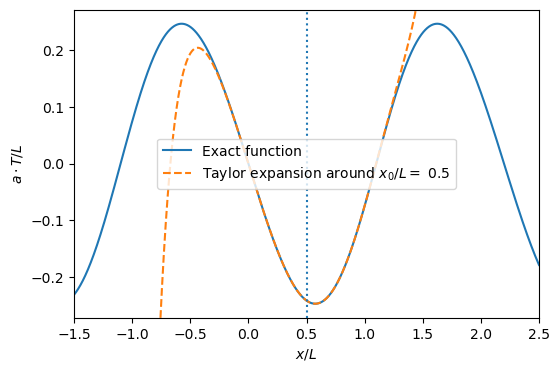

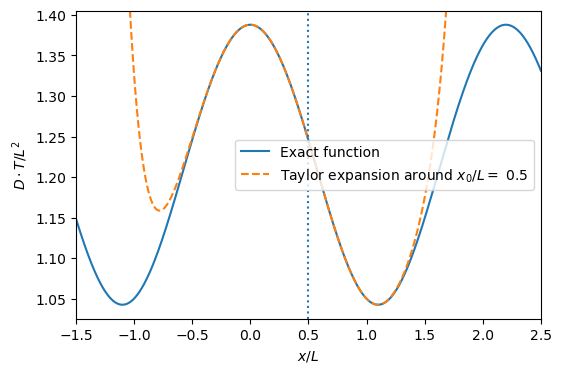

In [14]:
# For illustration, we construct the Taylor series of a and D at x0,
# and compare to the actual functions

def plot_taylor_vs_exact(derivatives_x0,
                        x0,
                        xP,
                        exact_lambda,
                        ylabel):
    #
    taylor_expansion = np.zeros_like(xP)
    for i,e in enumerate(derivatives_x0):
        #
        taylor_expansion += (xP - x0)**i * e / factorial(i)
    #
    fig,ax = plt.subplots(1,1,figsize=(6,4))
    yP_exact = exact_lambda(xP)
    ax.plot(xP,yP_exact,
            label=r'Exact function')
    ax.plot(xP,taylor_expansion,ls='--',
            label=r'Taylor expansion around $x_0/L =$ {0}'.format(x0))
    ax.axvline(x0,ls='dotted')
    ax.set_xlim(x0-2,x0+2)
    scale = np.fabs( np.max(yP_exact) - np.min(yP_exact) )
    ax.set_ylim(np.min(yP_exact) - 0.05*scale,
                np.max(yP_exact) + 0.05*scale)
    ax.set_xlabel(r'$x/L$')
    ax.set_ylabel(ylabel)
    ax.legend(loc='best')
    plt.show()
    plt.close(fig)


a_tilde_y_lambda = sp.lambdify(y,a_tilde_y)
a_lambda = lambda x: a_tilde_y_lambda(Phi_inverse_lambda(x))
plot_taylor_vs_exact(derivatives_x0=a_x0,
                    x0=x0,
                    xP=xP,
                    exact_lambda=a_lambda,
                    ylabel=r'$a \cdot T/L$')

D_tilde_y_lambda = sp.lambdify(y,D_tilde_y)
D_lambda = lambda x: D_tilde_y_lambda(Phi_inverse_lambda(x))
plot_taylor_vs_exact(derivatives_x0=D_x0,
                    x0=x0,
                    xP=xP,
                    exact_lambda=D_lambda,
                    ylabel=r'$D \cdot T/L^2$')

## Save results

In [15]:
np.shape(P) # (order of derivative, time, position)

(3, 181, 50001)

In [16]:
output_dictionary = {'D0':D0, # in units of L^2/T
                     'x0':x0, # in units of L
                     'y0':y0, # in units of L
                     't_breakdown':1/(8*D_x0[0]), # in units of T
                    #
                    'xP':xP, # in units of L
                    'yP':yP, # in units of L
                    'dt':dt, # in units of T
                    'P':P, # this is P(x,t | x_0, t_0) and its spatial 
                    # derivatives, evaluated on xP, dt.
                    # P_out[i,j,k] = i-th spatial derivative of P evaluated at 
                    # lagtime dt[j] and position x[k], in units 1/L^{i+1}
                     #
                     'a_x0':a_x0, 
                     'D_x0':D_x0,
                     #
                     'a_xP':a_xP, 
                     'D_xP':D_xP,
                     #
                    'x_midpoints':x_midpoints, # in units of L
                     'a_midpoints':a_midpoints,
                     'D_midpoints':D_midpoints,
                    }

with h5py.File('analytical_solution.h5','w') as f:
    #
    for key, value in output_dictionary.items():
        f.create_dataset(key,data=value)
    